In [19]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [2]:
bank_table = pd.read_csv('bank.csv')
bank_table.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998


In [3]:
# Creating a SQLite database connection and writing the DataFrame to a
# SQLite database table
conn = sqlite3.connect('bank.db')
db = conn.cursor()
bank_table.to_sql('bank_table', conn, if_exists='replace', index=False)

10127

Some SQL queries to get to explore the data

In [4]:
# Function to check the size of the dataset
def size_dataset(db):
    query =  "SELECT COUNT(*) FROM bank_table"
    db.execute(query)
    row = db.fetchone()
    return row

print(f'The dataset contains {size_dataset(db)[0]} rows.')

# Function to check the number of unique clients

def unique_clients(db):
    query = "SELECT COUNT(DISTINCT(CLIENTNUM)) FROM bank_table"
    db.execute(query)
    rows = db.fetchall()
    return rows
print(f'The dataset contains {unique_clients(db)[0][0]} unique clients.')

# In both cases, I get 10,127 as a result, which means that effectively the dataset contains the information of unique customers.

The dataset contains 10127 rows.
The dataset contains 10127 unique clients.


In [5]:
# Some basic queries to check the customer profiles/demographics

def gender(db):
    query = "SELECT DISTINCT(Gender), COUNT(*) FROM bank_table GROUP BY Gender"
    db.execute(query)
    rows = db.fetchall()
    return rows

print(gender(db))
print(f'{gender(db)[0][1]} of the clients are females, while {gender(db)[1][1]} are males.')


def avg_age(db):
    query = "SELECT AVG(Customer_Age) FROM bank_table"
    db.execute(query)
    row = db.fetchone()
    return row

print(f'The average age of the clients is {round(avg_age(db)[0])}.')

def avg_age_per_gender(db):
    query = "SELECT DISTINCT(Gender), AVG(Customer_Age) FROM bank_table GROUP BY Gender"
    db.execute(query)
    row = db.fetchall()
    return row

print(avg_age_per_gender(db))

[('F', 5358), ('M', 4769)]
5358 of the clients are females, while 4769 are males.
The average age of the clients is 46.
[('F', 46.45688689809631), ('M', 46.17886349339484)]


In [6]:
def income_category(db):
    query = "SELECT Income_category, count(CLIENTNUM) as customer_count FROM bank_table GROUP BY Income_Category ORDER BY customer_count"
    db.execute(query)
    rows = db.fetchall()
    return rows

#print(income_category(db))
print(f'There are {len(income_category(db))} different types of income categories. They are as follows:\n 1) {income_category(db)[0][0]} with {income_category(db)[0][1]} clients.\n 2) {income_category(db)[1][0]} with {income_category(db)[1][1]} clients.\n 3) {income_category(db)[2][0]} with {income_category(db)[2][1]} clients.\n 4) {income_category(db)[3][0]} with {income_category(db)[3][1]} clients.\n 5) {income_category(db)[4][0]} with {income_category(db)[4][1]} clients.\n 6) {income_category(db)[5][0]} with {income_category(db)[5][1]} clients.')

There are 6 different types of income categories. They are as follows:
 1) $120K + with 727 clients.
 2) Unknown with 1112 clients.
 3) $60K - $80K with 1402 clients.
 4) $80K - $120K with 1535 clients.
 5) $40K - $60K with 1790 clients.
 6) Less than $40K with 3561 clients.


In [7]:
def income_category_gender(db):
    query = """
    SELECT Income_Category,
           SUM(CASE WHEN Gender = 'M' THEN 1 ELSE 0 END) AS M,
           SUM(CASE WHEN Gender = 'F' THEN 1 ELSE 0 END) AS F
    FROM bank_table
    GROUP BY Income_Category
    ORDER BY Income_Category
    """
    db.execute(query)
    rows = db.fetchall()
    return rows

def print_income_category_gender(rows):
    print("{:<20}{:<15}{:<15}".format("Income Category", "Male Count", "Female Count"))
    for row in rows:
        income_category, male_count, female_count = row
        print("{:<20}{:<15}{:<15}".format(income_category, male_count, female_count))

rows = income_category_gender(db)
print_income_category_gender(rows)

print(f'\nThe table above interestingly shows that there are no female clients in the 3 highest income categories. \nThey are only below 60k.')


Income Category     Male Count     Female Count   
$120K +             727            0              
$40K - $60K         776            1014           
$60K - $80K         1402           0              
$80K - $120K        1535           0              
Less than $40K      277            3284           
Unknown             52             1060           

The table above interestingly shows that there are no female clients in the 3 highest income categories. 
They are only below 60k.


In [8]:
def card_category(db):
    query = "SELECT Card_Category, COUNT(*) as avg_credit_lim FROM bank_table GROUP BY Card_Category"
    db.execute(query)
    rows = db.fetchall()
    return rows
results_card_category = card_category(db)

for card in results_card_category:
    print(f'{card[0]} category cards are held by {card[1]} clients.')


Blue category cards are held by 9436 clients.
Gold category cards are held by 116 clients.
Platinum category cards are held by 20 clients.
Silver category cards are held by 555 clients.


In [9]:
def closed_opened_account(db):
    query = "SELECT closed_accounts,total_accounts, (closed_accounts / CAST(total_accounts AS FLOAT)) * 100 AS percentage FROM (SELECT SUM(CASE WHEN Attrition_Flag = 'Attrited Customer' THEN 1 ELSE 0 END) AS closed_accounts, COUNT(CLIENTNUM) AS total_accounts FROM bank_table) AS subquery_alias"
    db.execute(query)
    rows = db.fetchall()
    return rows

print(closed_opened_account(db)[0])

print(f'Out of the {closed_opened_account(db)[0][1]} customers in the dataset, there are {closed_opened_account(db)[0][0]} attrited customers, which account for {round(closed_opened_account(db)[0][2],2)}% of the total.')

(1627, 10127, 16.065962279055988)
Out of the 10127 customers in the dataset, there are 1627 attrited customers, which account for 16.07% of the total.


Deep-diving into the churn customers

From the histogram, the churn rate of customers seems to be more distributed in the lower end of transactions amount.
As we can see in the second plot, the graph is left-skewed for attrited customers.
This information might be important for the analysis and draw conclusions later on.


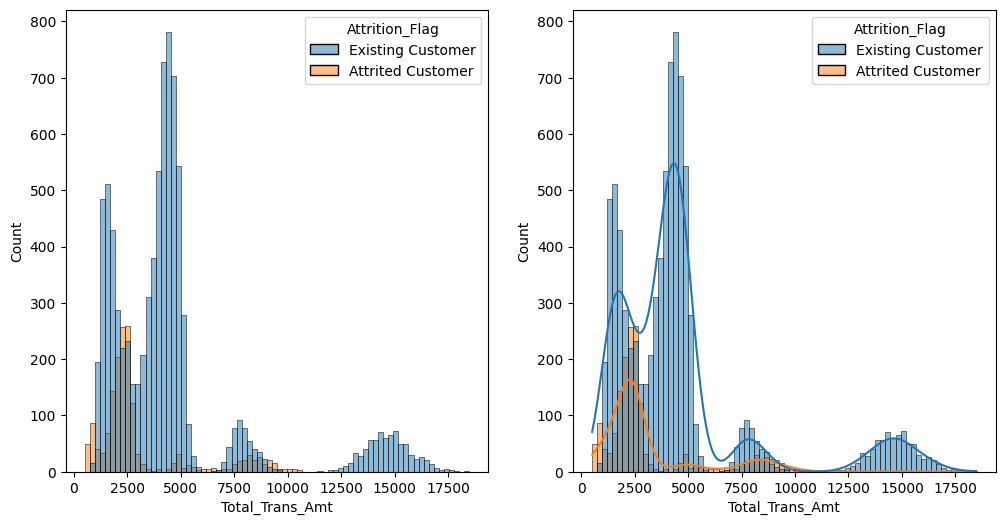

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))

sns.histplot(bank_table, x = 'Total_Trans_Amt', hue="Attrition_Flag", ax=axes[0])
sns.histplot(bank_table, x = 'Total_Trans_Amt', hue="Attrition_Flag", kde=True , ax = axes[1])

print(f'From the histogram, the churn rate of customers seems to be more distributed in the lower end of transactions amount.\nAs we can see in the second plot, the graph is left-skewed for attrited customers.\nThis information might be important for the analysis and draw conclusions later on.')

In [14]:
bank_table['Education_Level'].unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

In [17]:
bank_table[(bank_table['Education_Level'] == 'Unknown') & (bank_table['Attrition_Flag'] == 'Attrited Customer')]


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
82,711013983,Attrited Customer,55,F,4,Unknown,Married,$40K - $60K,Blue,45,...,2158.0,0,2158.0,0.585,615,12,0.714,0.000,0.99763,0.002366
99,711887583,Attrited Customer,47,M,2,Unknown,Married,$80K - $120K,Blue,37,...,5449.0,1628,3821.0,0.696,836,18,0.385,0.299,0.99700,0.002997
172,708953883,Attrited Customer,53,M,2,Unknown,Married,$80K - $120K,Blue,36,...,3212.0,0,3212.0,0.713,757,20,0.250,0.000,0.98692,0.013080
240,710299608,Attrited Customer,53,F,2,Unknown,Married,Less than $40K,Blue,33,...,2859.0,2517,342.0,0.993,817,30,0.667,0.880,0.99700,0.002997
337,709278258,Attrited Customer,54,M,2,Unknown,Married,$40K - $60K,Blue,44,...,2902.0,2517,385.0,0.821,996,26,0.444,0.867,0.99497,0.005030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10023,715154058,Attrited Customer,49,F,0,Unknown,Married,Less than $40K,Blue,39,...,4982.0,2517,2465.0,0.903,9274,65,0.857,0.505,0.99651,0.003491
10071,713281833,Attrited Customer,37,M,3,Unknown,Single,$40K - $60K,Blue,29,...,13589.0,2517,11072.0,0.941,9456,79,1.026,0.185,0.99544,0.004558
10089,720328983,Attrited Customer,52,F,5,Unknown,Married,Less than $40K,Blue,36,...,9611.0,0,9611.0,0.840,7636,64,0.829,0.000,0.99710,0.002904
10118,713755458,Attrited Customer,50,M,1,Unknown,Unknown,$80K - $120K,Blue,36,...,9959.0,952,9007.0,0.825,10310,63,1.100,0.096,0.99813,0.001874


In [33]:
label_encoder = LabelEncoder()

# Apply label encoding to 'education_level' column
bank_table['education_level_encoded'] = label_encoder.fit_transform(bank_table['Education_Level'])

# Display the DataFrame


In [38]:
bank_table.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

<AxesSubplot:xlabel='education_level_encoded', ylabel='Count'>

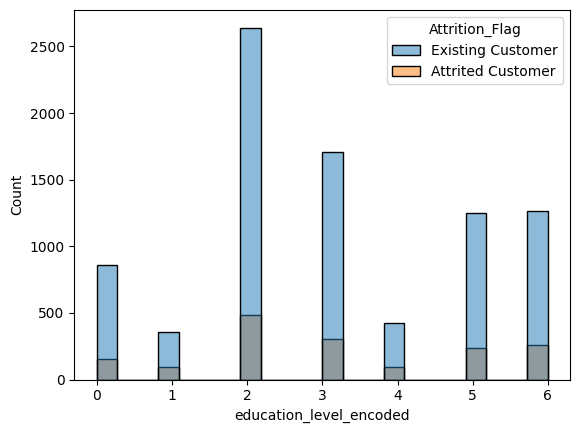

In [41]:
sns.histplot(bank_table, x = 'education_level_encoded', hue="Attrition_Flag")

<AxesSubplot:xlabel='Months_on_book', ylabel='Count'>

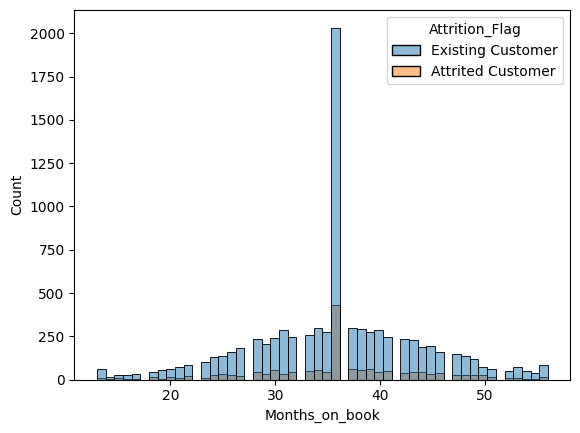

In [42]:
sns.histplot(bank_table, x = 'Months_on_book', hue="Attrition_Flag")

<AxesSubplot:xlabel='Months_Inactive_12_mon', ylabel='Count'>

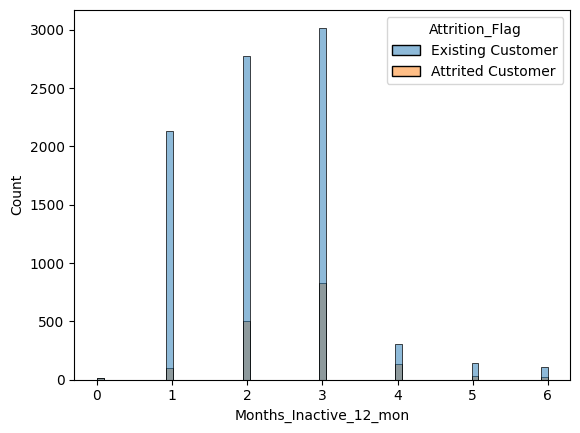

In [44]:
sns.histplot(bank_table, x = 'Months_Inactive_12_mon', hue="Attrition_Flag")

<AxesSubplot:xlabel='Avg_Utilization_Ratio', ylabel='Count'>

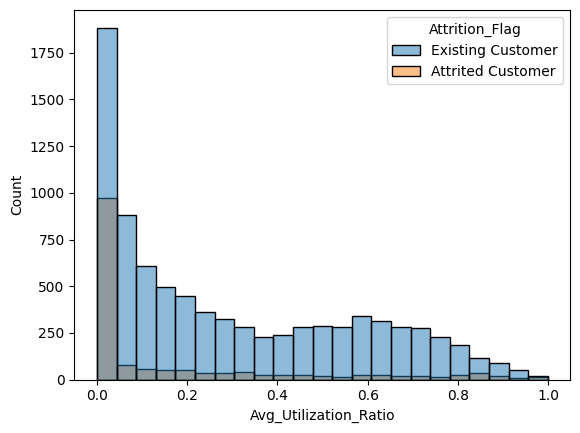

In [47]:
sns.histplot(bank_table, x = 'Avg_Utilization_Ratio', hue="Attrition_Flag")

In [48]:
label_encoder1 = LabelEncoder()

# Apply label encoding to 'education_level' column
bank_table['marital_status_encoded'] = label_encoder1.fit_transform(bank_table['Marital_Status'])


In [49]:
bank_table

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,education_level_encoded,marital_status_encoded
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910,3,1
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940,2,2
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980,2,1
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870,3,3
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810,2,2
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729,6,0
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118,3,1
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294,2,3


<AxesSubplot:xlabel='Credit_Limit', ylabel='Count'>

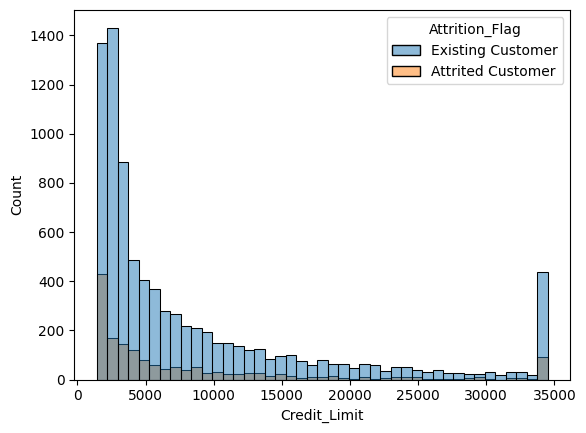

In [65]:
sns.histplot(bank_table, x = 'Credit_Limit', hue="Attrition_Flag")

<AxesSubplot:xlabel='Credit_Limit', ylabel='Count'>

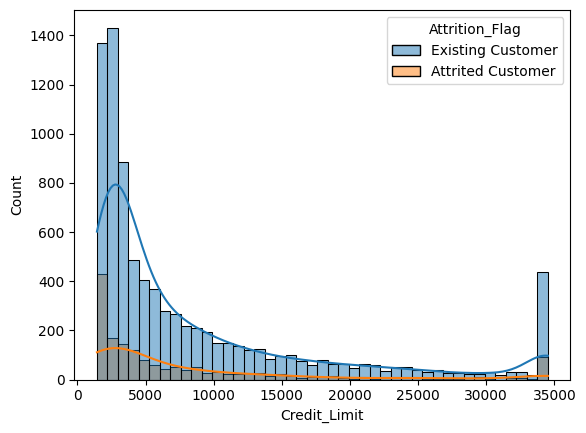

In [66]:
sns.histplot(bank_table, x = 'Credit_Limit', hue="Attrition_Flag", kde=True)
